In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | RANDOM FOREST | ALL VARIABLES WITHOUT RESEARCH

### Is it still possible to predict which observations decrease $\alpha_R$ without the strongest influence of research variables?

In [2]:
import sys
sys.path.append('../../')
import tokamakTK


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

In [4]:
features = ['ZEFFNEO', 'EPS', 'WFICFORM', 'DWDIA', 'KAREA', 
            'OMEGACYCL', 'ENBI', 'WMHD', 'AMIN', 'WFFORM', 'PICRH', 'PLTH', 'MEFF', 
            'QCYL5', 'PNBI', 'VOL', 'LCOULOMB', 'LHTIME', 'PFLOSS', 'BEIMHD', 
            'POHM', 'ZEFF', 'PECRH', 'ELMFREQ', 'PRAD', 'NESOL', 'TORQ', 'TOK', 'WALMAT', 'DIVNAME', 
            'LIMMAT', 'HYBRID', 'EVAP', 'ECHMODE', 'PREMAG', 'DIVMAT', 'PELLET', 'ELMTYPE', 'AUXHEAT', 'CONFIG']


DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

In [5]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [6]:
# Define random forest classifier with preprocessor as a pipeline

rf = RandomForestClassifier(min_samples_split=2,
                            min_samples_leaf=1,
                            n_estimators = 300,
                            max_depth = 25,
                            criterion='entropy',
                            max_features=None,
                            random_state=71
                           )


"""
rf = RandomForestClassifier()


"""

rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

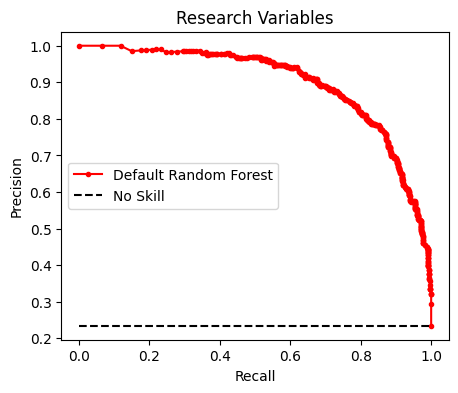

In [7]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [8]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.85384615, 0.92799462]),
 array([0.75681818, 0.96030641]),
 array([0.80240964, 0.94387406]),
 array([ 440, 1436]))

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [9]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

print(feature_importances)

            feature  importance
0          LCOULOMB    0.174110
1             QCYL5    0.103397
2              ENBI    0.075748
3              POHM    0.070498
4         OMEGACYCL    0.049353
..              ...         ...
134     DIVMAT_TI12    0.000000
135  DIVMAT_UNKNOWN    0.000000
136         TOK_PDX    0.000000
137        TOK_PBXM    0.000000
138  CONFIG_UNKNOWN    0.000000

[139 rows x 2 columns]


In [10]:
df = pd.DataFrame(feature_importances)
df.feature.unique()

array(['LCOULOMB', 'QCYL5', 'ENBI', 'POHM', 'OMEGACYCL', 'VOL', 'PFLOSS',
       'AMIN', 'PLTH', 'PNBI', 'KAREA', 'NESOL', 'EPS', 'HYBRID_HYBRID',
       'MEFF', 'WFFORM', 'PICRH', 'HYBRID_UNKNOWN', 'DWDIA', 'BEIMHD',
       'PECRH', 'HYBRID_YES', 'WMHD', 'ELMTYPE_TYPE-II', 'ZEFFNEO',
       'ECHMODE_NONE', 'WFICFORM', 'ZEFF', 'PELLET_D', 'EVAP_NONE',
       'PELLET_NONE', 'PRAD', 'LHTIME', 'ELMTYPE_TYPE-III', 'TOK_AUG',
       'HYBRID_NO', 'PELLET_GAS-FUEL', 'AUXHEAT_NB', 'ECHMODE_UNKNOWN',
       'DIVMAT_C/BE', 'TORQ', 'ELMTYPE_TYPE-I', 'CONFIG_SN(U)', 'EVAP_BO',
       'AUXHEAT_NBIC', 'CONFIG_SN(L)', 'ELMTYPE_UNKNOWN', 'ELMFREQ',
       'PREMAG_YES', 'DIVMAT_C', 'DIVNAME_DV-II', 'CONFIG_DN', 'WALMAT_C',
       'PELLET_H', 'DIVNAME_MARK', 'LIMMAT_C', 'EVAP_BE', 'WALMAT_C-W',
       'LIMMAT_BE', 'PREMAG_UNKNOWN', 'DIVNAME_DV-III', 'PREMAG_NO',
       'DIVNAME_MARKSR', 'WALMAT_IN', 'TOK_JETILW', 'DIVNAME_MARKIAP',
       'AUXHEAT_NBEC', 'TOK_D3D', 'DIVNAME_ILW', 'WALMAT_IN/C',
       '

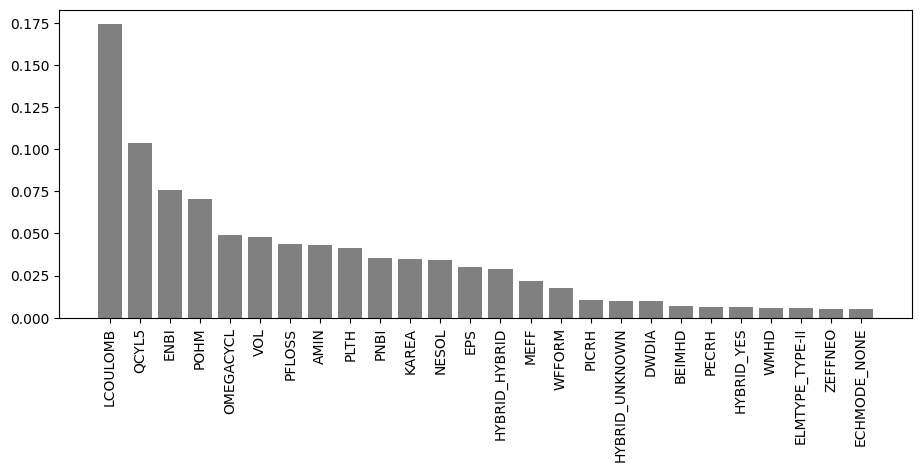

In [11]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

In [12]:
# Quite Important
df[df.importance > 1e-3]

feature  importance
0           LCOULOMB    0.174110
1              QCYL5    0.103397
2               ENBI    0.075748
3               POHM    0.070498
4          OMEGACYCL    0.049353
5                VOL    0.047687
6             PFLOSS    0.043967
7               AMIN    0.043234
8               PLTH    0.041498
9               PNBI    0.035250
10             KAREA    0.035087
11             NESOL    0.034366
12               EPS    0.030054
13     HYBRID_HYBRID    0.028860
14              MEFF    0.021750
15            WFFORM    0.017759
16             PICRH    0.010281
17    HYBRID_UNKNOWN    0.010103
18             DWDIA    0.009946
19            BEIMHD    0.006767
20             PECRH    0.006134
21        HYBRID_YES    0.006083
22              WMHD    0.005842
23   ELMTYPE_TYPE-II    0.005518
24           ZEFFNEO    0.005286
25      ECHMODE_NONE    0.005143
26          WFICFORM    0.004750
27              ZEFF    0.004451
28          PELLET_D    0.004278
29         EVAP_NONE    0.004276
30       PELLET_NONE    0.004144
31              PRAD    0.004025
32            LHTIME    0.004016
33  ELMTYPE_TYPE-III    0.003754
34           TOK_AUG    0.002823
35         HYBRID_NO    0.002303
36   PELLET_GAS-FUEL    0.001947
37        AUXHEAT_NB    0.001917
38   ECHMODE_UNKNOWN    0.001916
39       DIVMAT_C/BE    0.001625
40              TORQ    0.001614
41    ELMTYPE_TYPE-I    0.001575
42      CONFIG_SN(U)    0.001484
43           EVAP_BO    0.001383
44      AUXHEAT_NBIC    0.001376
45      CONFIG_SN(L)    0.001331
46   ELMTYPE_UNKNOWN    0.001321
47           ELMFREQ    0.001277
48        PREMAG_YES    0.001108
49          DIVMAT_C    0.001062

In [13]:
# Not so important
df[df.importance < 1e-3]

feature  importance
50    DIVNAME_DV-II    0.000938
51        CONFIG_DN    0.000887
52         WALMAT_C    0.000833
53         PELLET_H    0.000698
54     DIVNAME_MARK    0.000670
..              ...         ...
134     DIVMAT_TI12    0.000000
135  DIVMAT_UNKNOWN    0.000000
136         TOK_PDX    0.000000
137        TOK_PBXM    0.000000
138  CONFIG_UNKNOWN    0.000000

[89 rows x 2 columns]

In [14]:
df[df.importance == 0]

feature  importance
107        TOK_ASDEX         0.0
108       CONFIG_TOP         0.0
109       CONFIG_BOT         0.0
110       CONFIG_MAR         0.0
111  AUXHEAT_UNKNOWN         0.0
112      TOK_COMPASS         0.0
113        CONFIG_IW         0.0
114       CONFIG_DND         0.0
115       CONFIG_LIM         0.0
116        TOK_START         0.0
117        TOK_JFT2M         0.0
118   PELLET_UNKNOWN         0.0
119   DIVNAME_MARKIA         0.0
120   LIMMAT_UNKNOWN         0.0
121   WALMAT_UNKNOWN         0.0
122           EVAP_C         0.0
123         EVAP_C-H         0.0
124     EVAP_DECABOA         0.0
125          EVAP_TI         0.0
126     EVAP_UNKNOWN         0.0
127        WALMAT_AL         0.0
128        ECHMODE_O         0.0
129         TOK_TFTR         0.0
130         TOK_TDEV         0.0
131        DIVMAT_IN         0.0
132      DIVMAT_NONE         0.0
133        DIVMAT_SS         0.0
134      DIVMAT_TI12         0.0
135   DIVMAT_UNKNOWN         0.0
136          TOK_PDX         0.0
137         TOK_PBXM         0.0
138   CONFIG_UNKNOWN         0.0